In [344]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [345]:
# fetch dataset 
iris = fetch_ucirepo(id=53) 
X = iris.data.features 
y = iris.data.targets 

In [346]:
# Change target feature from string to int
y['class'] = y['class'].replace('Iris-setosa', 0)
y['class'] = y['class'].replace('Iris-versicolor', 1)
y['class'] = y['class'].replace('Iris-virginica', 2)
y

/tmp/ipykernel_312879/1692529871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['class'] = y['class'].replace('Iris-setosa', 0)
/tmp/ipykernel_312879/1692529871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['class'] = y['class'].replace('Iris-versicolor', 1)
/tmp/ipykernel_312879/1692529871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

,class
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


In [348]:
# Train test split

X = np.array(X[['sepal length', 'sepal width', 'petal length', 'petal width']])
y = np.array(y['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [349]:
# Convert X features to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [350]:
# Create a Model class that inherits nn.Module

# why is pytorch code in class based object oriented programming

class Model(nn.Module):
    # Input layer (4 features of the flower) --> 
    # Hidden layer1 (number of neurons) --> 
    # H2 (n) --> 
    # output (3 classes of iris flowers)
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        super().__init__() # instantiate the nn.module
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        
        return x

In [351]:
# Pick a manual seed for randomization
torch.manual_seed(41)
# Create an instance of model
model = Model()

In [352]:
# Convert y labels to tensors long (for 64 bit integers)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Make the tensors 1D because the loss function expects 0D or 1D
# y_train = torch.argmax(y_train, dim=1)
# y_test = torch.argmax(y_test, dim=1)

In [353]:
# Set the criterion of model to measure the error, how far off the predictions are from the data
criterion = nn.CrossEntropyLoss()
# Using SGD for full-batch gradient descent with entire dataset at once and defining the Learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

In [354]:
model.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)>

In [355]:
# Train our model

epochs = 100
losses = []
for i in range(epochs):
    # Forward pass
    y_pred = model.forward(X_train) # Get predicted results
    
    # Measure the loss
    loss = criterion(y_pred, y_train) 
    
    # Keep track of the losses
    losses.append(loss.detach().numpy()) # The loss output comes a tensor type. By using detach, it will be usable for plotting
    
    # Print every 10 epoch
    if i % 10 == 0:
        print(f'Epoch: {i} and loss: {loss}')
        
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 and loss: 1.125285267829895
Epoch: 10 and loss: 1.0745165348052979
Epoch: 20 and loss: 1.0432014465332031
Epoch: 30 and loss: 0.9988870620727539
Epoch: 40 and loss: 0.9283655881881714
Epoch: 50 and loss: 0.8290789127349854
Epoch: 60 and loss: 0.7272171378135681
Epoch: 70 and loss: 0.6337546110153198
Epoch: 80 and loss: 0.5455329418182373
Epoch: 90 and loss: 0.471472829580307


Text(0.5, 0, 'epoch')

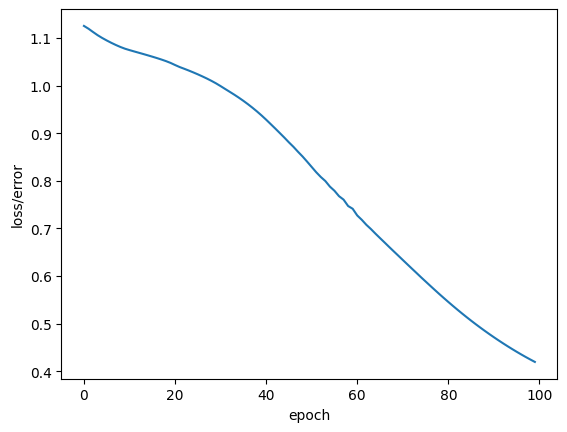

In [356]:
# Graph the results

plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel("epoch")

In [357]:
# Evaluate the model on test data set (validate model on test set)
with torch.no_grad(): # Basically turn off back propogation
    y_eval = model.forward(X_test) 
    loss = criterion(y_eval, y_test)

In [358]:
loss

tensor(0.4022)

In [359]:
correct = 0
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.forward(data)
        
        # Will tell us what type of flower the network thinks it is
        print(f'{i+1}.) {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')
        
        # Correct or not 
        if y_val.argmax().item() == y_test[i]:
            correct += 1

print(f'We got {correct} correct!')

1.) tensor([-1.4788,  1.3165,  1.2735]) 	 1 	 1
2.) tensor([ 2.2457, -0.2927, -0.7042]) 	 0 	 0
3.) tensor([-2.8993,  1.8251,  3.0807]) 	 2 	 2
4.) tensor([-1.5154,  1.3351,  1.3164]) 	 1 	 1
5.) tensor([-1.5705,  1.3921,  1.3280]) 	 1 	 1
6.) tensor([ 2.1250, -0.2459, -0.6921]) 	 0 	 0
7.) tensor([-0.6615,  1.0369,  0.6110]) 	 1 	 1
8.) tensor([-2.1309,  1.5833,  2.0491]) 	 2 	 2
9.) tensor([-1.6390,  1.3728,  1.4991]) 	 1 	 2
10.) tensor([-0.9031,  1.1262,  0.7679]) 	 1 	 1
11.) tensor([-1.9818,  1.5062,  1.9014]) 	 2 	 2
12.) tensor([ 2.0176, -0.2062, -0.6893]) 	 0 	 0
13.) tensor([ 2.3397, -0.3284, -0.7103]) 	 0 	 0
14.) tensor([ 2.0220, -0.2079, -0.6895]) 	 0 	 0
15.) tensor([ 2.1709, -0.2643, -0.6993]) 	 0 	 0
16.) tensor([-1.5736,  1.3767,  1.3390]) 	 1 	 1
17.) tensor([-2.4422,  1.6248,  2.5866]) 	 2 	 2
18.) tensor([-0.9781,  1.1392,  0.8008]) 	 1 	 1
19.) tensor([-1.4495,  1.2882,  1.2794]) 	 1 	 1
20.) tensor([-2.3938,  1.6050,  2.5362]) 	 2 	 2
21.) tensor([ 1.9029, -0.1615